In [3]:
# imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

import sklearn
import imblearn

sns.set(style="whitegrid")

In [4]:
sklearn.__version__, imblearn.__version__

('1.5.1', '0.12.3')

In [5]:
df = pd.read_csv("./dataset/creditcard.csv")  # adjust path if needed

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [8]:
df.isnull().sum().max()

0

In [9]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [10]:
df['Class'].value_counts(normalize=True)

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64

### EDA

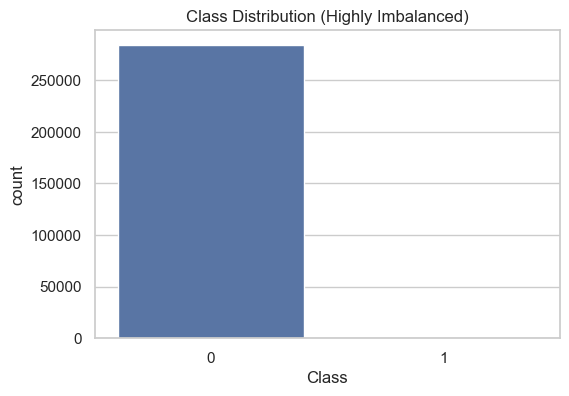

In [13]:
# class imbalance
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (Highly Imbalanced)")
plt.show()

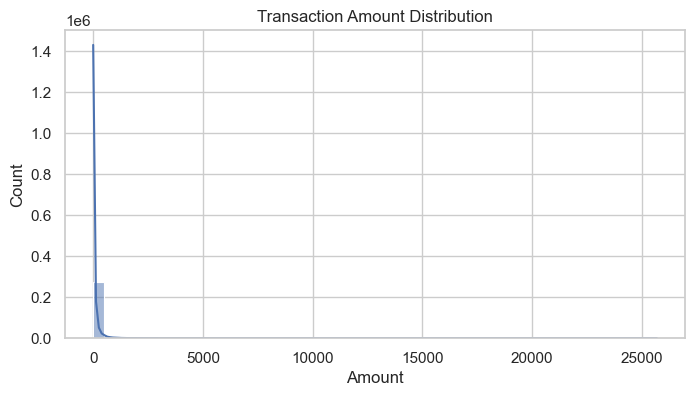

In [14]:
# Distribution of amount
plt.figure(figsize=(8,4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


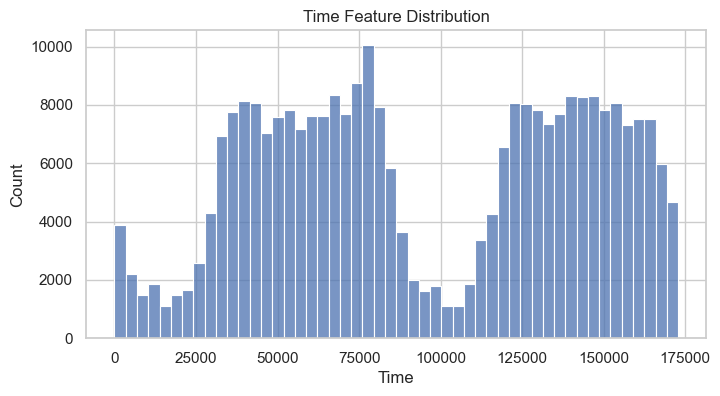

In [15]:
# Time feature
plt.figure(figsize=(8,4))
sns.histplot(df['Time'], bins=50)
plt.title("Time Feature Distribution")
plt.show()


In [16]:
# Separate Features and Target
X = df.drop('Class', axis=1)
y = df['Class']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [18]:
print("Train class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Train class distribution:
Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64

Test class distribution:
Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [19]:
# Scaling
scaler = RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[['Time', 'Amount']] = scaler.fit_transform(
    X_train[['Time', 'Amount']]
)

X_test_scaled[['Time', 'Amount']] = scaler.transform(
    X_test[['Time', 'Amount']]
)

### Baseline Model

In [20]:
lr = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
y_pred = lr.predict(X_test_scaled)
y_proba = lr.predict_proba(X_test_scaled)[:, 1]

In [22]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8289    0.6429    0.7241        98

    accuracy                         0.9992     56962
   macro avg     0.9142    0.8213    0.8619     56962
weighted avg     0.9991    0.9992    0.9991     56962



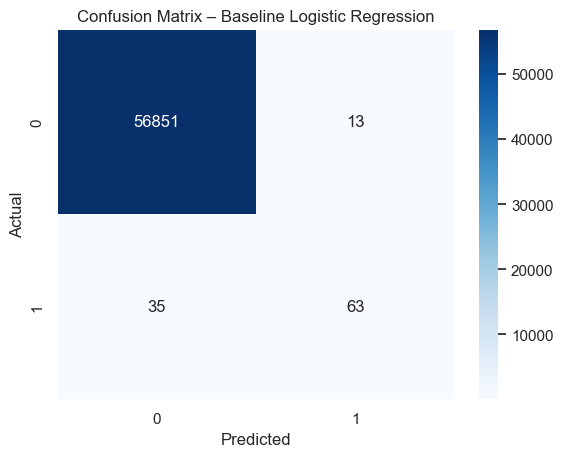

In [23]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Baseline Logistic Regression")
plt.show()

In [24]:
roc_auc = roc_auc_score(y_test, y_proba)
roc_auc

0.9572334420543681

### Random Undersampling

In [25]:
# Combine X and y for undersampling
train_df = X_train_scaled.copy()
train_df['Class'] = y_train.values

# Separate classes
fraud = train_df[train_df['Class'] == 1]
normal = train_df[train_df['Class'] == 0]

# Undersample majority class
normal_sampled = normal.sample(
    n=len(fraud),
    random_state=42
)

undersampled_df = pd.concat([fraud, normal_sampled])

undersampled_df['Class'].value_counts()

Class
1    394
0    394
Name: count, dtype: int64

In [26]:
# Shuffle and Split again
undersampled_df = undersampled_df.sample(frac=1, random_state=42)

X_train_under = undersampled_df.drop('Class', axis=1)
y_train_under = undersampled_df['Class']

In [27]:
lr_under = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_under.fit(X_train_under, y_train_under)

LogisticRegression(max_iter=1000, random_state=42)

In [ ]:
# evaluating on original test set
y_pred_under = lr_under.predict(X_test_scaled)
y_proba_under = lr_under.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_under, digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9604    0.9797     56864
           1     0.0384    0.9184    0.0737        98

    accuracy                         0.9603     56962
   macro avg     0.5191    0.9394    0.5267     56962
weighted avg     0.9982    0.9603    0.9782     56962



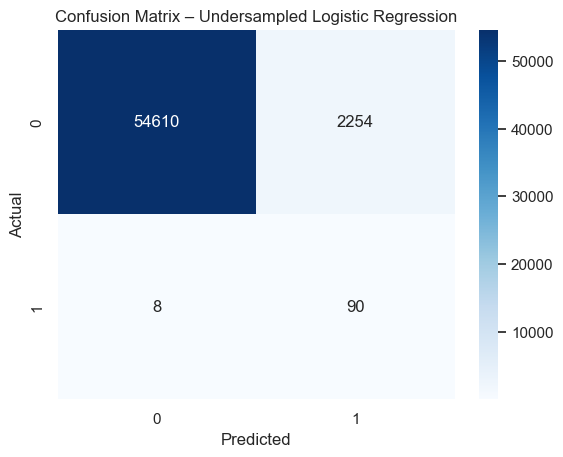

In [29]:
cm_under = confusion_matrix(y_test, y_pred_under)

sns.heatmap(
    cm_under,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – Undersampled Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### SMOTE Oversampling

In [30]:
smote = SMOTE(
    sampling_strategy='auto',
    random_state=42
)

X_train_smote, y_train_smote = smote.fit_resample(
    X_train_scaled,
    y_train
)

y_train_smote.value_counts()

c:\Users\Abhimanyu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Abhimanyu\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Abhimanyu\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Abhimanyu\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\Abhimanyu\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid

Class
0    227451
1    227451
Name: count, dtype: int64

In [31]:
lr_smote = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(max_iter=1000, random_state=42)

In [32]:
y_pred_smote = lr_smote.predict(X_test_scaled)
y_proba_smote = lr_smote.predict_proba(X_test_scaled)[:, 1]

print(classification_report(y_test, y_pred_smote, digits=4))

              precision    recall  f1-score   support

           0     0.9999    0.9747    0.9871     56864
           1     0.0589    0.9184    0.1106        98

    accuracy                         0.9746     56962
   macro avg     0.5294    0.9465    0.5489     56962
weighted avg     0.9982    0.9746    0.9856     56962



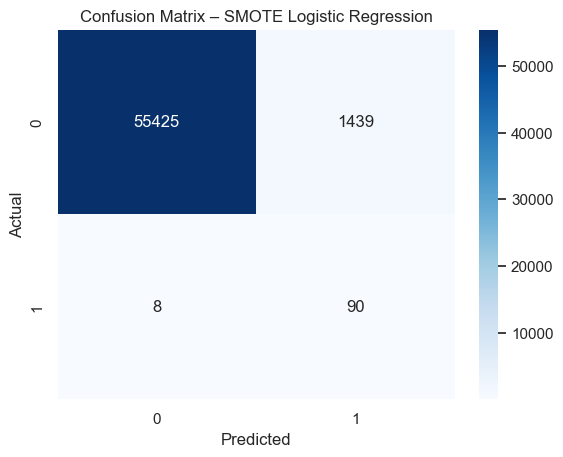

In [33]:
cm_smote = confusion_matrix(y_test, y_pred_smote)

sns.heatmap(
    cm_smote,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – SMOTE Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### NearMiss Undersampling

In [34]:
nearmiss = NearMiss(version=1)

X_train_nm, y_train_nm = nearmiss.fit_resample(
    X_train_scaled,
    y_train
)

y_train_nm.value_counts()


Class
0    394
1    394
Name: count, dtype: int64

In [35]:
lr_nm = LogisticRegression(
    max_iter=1000,
    random_state=42
)

lr_nm.fit(X_train_nm, y_train_nm)


LogisticRegression(max_iter=1000, random_state=42)

In [36]:
y_pred_nm = lr_nm.predict(X_test_scaled)

print(classification_report(y_test, y_pred_nm, digits=4))


              precision    recall  f1-score   support

           0     0.9999    0.6240    0.7684     56864
           1     0.0044    0.9592    0.0087        98

    accuracy                         0.6246     56962
   macro avg     0.5021    0.7916    0.3886     56962
weighted avg     0.9982    0.6246    0.7671     56962



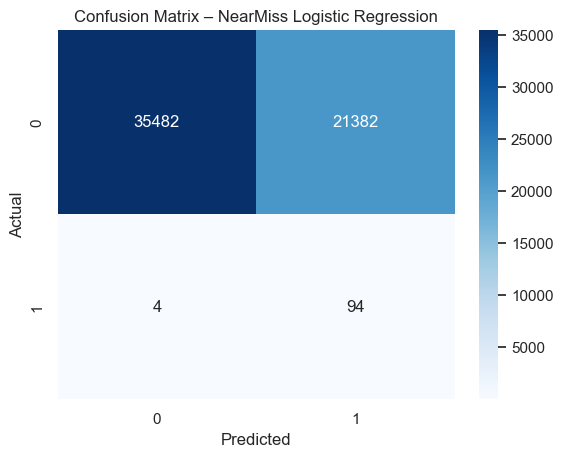

In [37]:
cm_nm = confusion_matrix(y_test, y_pred_nm)

sns.heatmap(
    cm_nm,
    annot=True,
    fmt="d",
    cmap="Blues"
)
plt.title("Confusion Matrix – NearMiss Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [38]:
results = pd.DataFrame({
    "Method": [
        "No Resampling",
        "Random Undersampling",
        "SMOTE",
        "NearMiss"
    ],
    "Recall_Class_1": [
        0.6429,
        0.9184,
        0.9184,
        0.9592
    ],
    "Precision_Class_1": [
        0.8289,
        0.0384,
        0.0589,
        0.0044
    ]
})

results


,Method,Recall_Class_1,Precision_Class_1
0,No Resampling,0.6429,0.8289
1,Random Undersampling,0.9184,0.0384
2,SMOTE,0.9184,0.0589
3,NearMiss,0.9592,0.0044
